<a href="https://colab.research.google.com/github/perfectpanda-works/machine-learning/blob/master/WHAT_IS_TORCH_NN_REALLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このチュートリアルでは、MNISTデータセットを利用して、基本的なニューラルネットワークを訓練します。最初はPyTorchのテンソルの機能のみで作成していきます。

また、このチュートリアルは、テンソルの操作の基本を知っていることが前提となっています。

##MNISTデータのセットアップ

MNISTは機械学習の有名なデータセットで、0～9の手書き数字（白黒画像）のデータです。分類問題として、正しく手書き数字を分類できるネットワークの訓練を目指します。

次のプログラム（Python3標準ライブラリのpathlibを利用）で、リクエストを利用して、MNISTデータセットをダウンロードします。

GoogleColaboで実行する場合、ファイルの「data/mnist/」に追加されます。

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

ここでダウンロードしたデータセットはnumpy形式で、python固有のpickelで保存されています。そのため、次のプログラムでデータを取り出します。

gzipをopenしたのち、pickel形式のデータを読み込んでいます。

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

この状態で、各画像は784個のデータの平坦化された行（１次元の配列）として保存されていますので、28×28の画像として変換する必要があります。

In [3]:
print(x_train[0].shape)

(784,)


reshapeメソッドで28×28の行列に変換してmatplotlibで表示してみます。

また、x_trainには50000個の手書き文字データが格納されています。

(50000, 784)


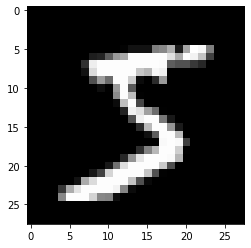

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorchでデータを利用するためにnumpyから「torch.tensor」に変換します。

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(n)
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

50000
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


#スクラッチでニューラルネットワーク(torch.nnを利用しない)

このチュートリアルを行う前に、ニューラルネットワークについての基本的な知識があることが前提となっています。

まずはニューラルネットワークのパラメータを保持する変数を作成します。

PyTorchの提供するメソッドでランダムな値で埋められたテンソルや、ゼロで埋められたテンソルを作成することができます。そして、そのテンソルをシンプルな線形モデルの重みやバイアスといったパラメータにすることができます。また、Tensorのもっとも重要な特徴は、勾配が計算できるという点です。テンソルに行われた計算を保持できるので、勾配を自動的に計算することができます。

次のプログラムで、ニューラルネットワークの「重み」と「バイアス」パラメータを作成します。

ニューラルネットの「重み」パラメータのためのテンソルは、初期化のすぐ後に「required_grad_()」で計算の追跡する設定にしています。（初期化の計算をした後に追跡開始することで、初期化の計算を含めない点がポイント）

また、重みのパラメータは、「Xavier　initialisation」という初期化方法を利用しています。

「バイアス」は、ゼロで初期化するとともに、「required_grad」フラグをTrueにしています。

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

PyTorchの自動的に勾配を計算（自動微分）してくれるおかげで、通常のPythonの関数などが利用できます。

次に、「活性化関数」を作成します。手動で「log_softmax」を定義しています。これは、Pythonの関数として定義します。

そして、「model」では、ニューラルネットワークのモデル自体を定義しています。モデルといっても、今回は、順伝播が行われるような式を定義しているだけになります。重みと入力テンソルを掛け合わせて、バイアスを足したものを活性化関数のlog_softmaxに入れ、出力値をリターンするようなモデルです。

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

上のプログラムの「@」は内積演算（行列積）を表しています。

そして、モデルには、バッチ単位でデータを渡します。（今回は64枚の画像）「xb」には64枚の画像が入ってくるということです。

実際には、xbが（64×784）の行列、そして、weightsは(784×10)の行列となります。

In [8]:
bs = 64  # バッチサイズ

xb = x_train[0:bs]  # ミニバッチサイズ
preds = model(xb)  # 順伝播で予測
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.4143, -2.7469, -2.0619, -1.8692, -1.9791, -2.3463, -2.5218, -2.5840,
        -2.3050, -2.5834], grad_fn=<SelectBackward>) torch.Size([64, 10])


「xb」には、訓練用画像「x_train」から0〜63枚目の画像（計64枚）が格納されます。

そして、その「xb」をmodelに入れることで、modelに計算をさせ、予測値をえます。（順伝播）

この予測値には、勾配も含まれていることが確認できます。これは後の逆伝播で利用します。

それでは、損失関数として「負の対数尤度関数（NLL)」を定義します。これは、Python標準の関数で作成しています。

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

それでは、損失を確認してみます。

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3443, grad_fn=<NegBackward>)


同様に、このモデルの精度を確認してみます。



In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [12]:
print(accuracy(preds, yb))

tensor(0.1250)


これで、訓練ループを実装できます。それぞれのループでは、次のことを行います。

・ミニバッチでデータを選択

・モデルで予測

・誤差を求める

・逆伝播をして勾配を求める

・重みを更新する

重みを更新する際には、重みの更新の計算を追跡しないようにtorch.no_grad()で囲みます。また、次のループに入る前に勾配をリセットするためにgrad_zero()を呼び出す必要があります。

学習率は「lr」、訓練回数は「epochs」で指定します。

（Python標準のデバッガも利用できるとのことです。）

In [13]:
from IPython.core.debugger import set_trace

lr = 0.5  # 学習率
epochs = 2  # 訓練のエポック数

print("n")
print(n)
print("bs")
print(bs)

#エポック回数分繰り返す
for epoch in range(epochs):
    batch_num=0
    #ミニバッチのループ
    #//は切り捨て除算
    for i in range((n - 1) // bs + 1):#(49999÷64)+1=782.23の切り捨て回数分のミニバッチ
        batch_num = batch_num + 1
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        #勾配降下法で重みの更新(式を手動で定義)
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print("mini_batch_num")
print(batch_num)

n
50000
bs
64
mini_batch_num
782


今回は、もっともミニマムなニューラルネットワークを作成しました。これは、ロジスティック回帰であり、隠れ層のないネットワークです。

訓練後の損失と精度を確認してみます。

In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0804, grad_fn=<NegBackward>) tensor(1.)


#リファクタリング

##torch.nn.functionalを使う


これから、スクラッチで作成したプログラムをpytorchのnnクラスを利用してより簡潔で柔軟なプログラムになるようにリファクタリングを行います。

ここからのステップでは、プログラムをより短く、理解しやすい形に変更していきます。

いちばん簡単なステップとしては、手動で定義していた損失関数を「torch.nn.functional」で置き換えることです。「torch.nn.functional」は一般的に「F」という名前空間でimportされます。

（Functionalは、「as F」とするのが一般的のようです。）

損失関数として、「負の尤度関数(negative log likelihood)」または「尤度関数(log softmax)」を利用している場合、PyTorchでは「F.cross_entropy」関数でカバーしています。これを利用して、損失関数をモジュールを利用して簡潔に記述することができます。

In [15]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

同じ損失と同じ精度が算出されることを確認しましょう。

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0804, grad_fn=<NllLossBackward>) tensor(1.)


##nn.Moduleでリファクタリング

次に、訓練ループを整理するために、「nn.Module」と「nn.Parameter」を利用します。

nn.Moduleのサブクラスとしてクラスを定義することで利用します。サブクラスでは、「重み、バイアス」といったネットワークの訓練パラメータを保持し、順伝播をメソッドとして実装していきたいです。nn.Moduleには、このようなサブクラスを作成するための「.Parameter()」や「zero_grad()」といった属性やメソッドが存在します。

In [17]:
#nnをimport
from torch import nn

#nn.Moduleを継承したMnistLogisticクラス
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        #コンストラクタで重み、バイアスの初期化
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    #forwardメソッドの定義
    def forward(self, xb):
        return xb @ self.weights + self.bias

クラスのコンストラクタでXavier　initialisationとバイアスのゼロ初期化を行うようになりました。

また、forwardをクラスのメソッドとして定義しました。nn.Moduleのクラスを利用することで、テンソルの追跡も自動的に行われるので、手動で行っていた時のようにRequired_gradを気にする必要もなくなりました。

定義したモデルをインスタンス化します。

In [18]:
model = Mnist_Logistic()

今までの記載方法と同じ記載で損失を計算することができます。

nn.Moduleのオブジェクトは関数のように使用することができます。関数のように呼び出すことで、自動的にforwardメソッドを実行してくれるようになっています。

In [27]:
print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward>)


以前の訓練方法では、それぞれのパラメータ（重み、バイアス）を変数名で指定して更新を行い、それぞれのパラメータの勾配を明示的に初期化を行わなければいけませんでした。

In [20]:
#いままでの手動での勾配降下法の実装
#with torch.no_grad():
#    weights -= weights.grad * lr
#    bias -= bias.grad * lr
#    weights.grad.zero_()
#    bias.grad.zero_()

nn.Moduleクラスを導入することで、「model.parameters()」でモデル全体のパラメータにアクセスができ、「model.zero_grad() 」でモデル全体のパラメータの勾配を一括で初期化できるようになりました。これは、もっと複雑なネットワークを定義するときにとても役に立ちます。重みの更新忘れなどの人為的ミスも防ぐことになります。

In [21]:
#with torch.no_grad():
#    for p in model.parameters(): p -= p.grad * lr
#    model.zero_grad()

このparameters()とzero_grad()を使った勾配降下法で訓練関数fit()を作成してみます。

In [22]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [23]:
print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


##nn.Linearでリファクタリング

次に、モデルの定義の中で、「self.weights」や「self.bias」と行った変数を定義して初期化していました。そして、「xb @ self.weights + self.bias」と順伝播の式を手動で定義していました。

中間層が増加すると、「weights」や「bias」と行った変数も中間層分増加することになり、順伝播の式もより複雑になっていきます。

今回のような線形な層の場合、nn.Linearを利用して、簡潔に記載することができます。線形の層以外の畳み込み層など一般的に利用されるものもpytorchに存在し、とても早く実装することができるようになります。

In [24]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        #入力が784次元、出力が10次元の線形の層を定義
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

このクラスは、以前と同様のプログラムでインスタンス化して、損失を計算することができます。

In [25]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2910, grad_fn=<NllLossBackward>)


先ほどリファクタリングした訓練用の関数であるfitも同様に利用することができます。

In [26]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward>)
